#### Step 1: *Import Primary Dataset*

In [1]:
import pandas as pd

df_movies = pd.read_csv('rotten_tomatoes_movies.csv')

#### Step 2: *Check columns and data types*

In [2]:
df_movies.dtypes

rotten_tomatoes_link                 object
movie_title                          object
movie_info                           object
critics_consensus                    object
content_rating                       object
genres                               object
directors                            object
authors                              object
actors                               object
original_release_date                object
streaming_release_date               object
runtime                             float64
production_company                   object
tomatometer_status                   object
tomatometer_rating                  float64
tomatometer_count                   float64
audience_status                      object
audience_rating                     float64
audience_count                      float64
tomatometer_top_critics_count         int64
tomatometer_fresh_critics_count       int64
tomatometer_rotten_critics_count      int64
dtype: object

#### Step 3: *Remove Unnecessary Columns*

In [3]:
df_movies = df_movies[['rotten_tomatoes_link', 'movie_title', 'directors', 'production_company']]

#### Step 4: *Check counts of null values*

In [4]:
null_counts = df_movies.isnull().sum()   #check counts of null values
null_counts

rotten_tomatoes_link      0
movie_title               0
directors               194
production_company      499
dtype: int64

#### Step 5: *Replace null values with N/A*

In [5]:
df_movies.fillna('N/A', inplace=True)  #Replace all null values with N/A indicating value not available
null_counts = df_movies.isnull().sum()                                                                                           
null_counts    

rotten_tomatoes_link    0
movie_title             0
directors               0
production_company      0
dtype: int64

#### Step 6: *Drop any available duplicates in rotten tomatoes link*

In [6]:
df_movies.drop_duplicates(subset=['rotten_tomatoes_link'], keep='last', inplace=True)

#### Step 7: *Import Secondary Dataset (which includes the movie reviews)*

In [7]:
df_movies_review = pd.read_csv('rotten_tomatoes_critic_reviews.csv')

#### Step 8: *Removal of unnecessary columns and Initial EDA*

In [8]:
df_movies_review = df_movies_review[['rotten_tomatoes_link', 'critic_name', 'review_type', 'review_content']]
df_movies_review.describe(include='all')

,rotten_tomatoes_link,critic_name,review_type,review_content
count,1130017,1111488,1130017,1064211
unique,17712,11108,2,949181
top,m/star_wars_the_rise_of_skywalker,Emanuel Levy,Fresh,Parental Content Review
freq,992,8173,720210,267


#### Step 9: *Remove rows with empty reviews, replace all other empty rows with N/A*

In [9]:
df_movies_review = df_movies_review[df_movies_review['review_content'].notna()]
df_movies_review.fillna('N/A', inplace=True)  #Replace all null values with N/A indicating value not available
null_counts=df_movies_review.isnull().sum()                                                                                           
null_counts   

rotten_tomatoes_link    0
critic_name             0
review_type             0
review_content          0
dtype: int64

#### Step 10: *Merge primary and secondary dataset by a common key, rotten_tomatoes_link*

In [10]:
df = pd.merge(df_movies_review, df_movies, how='inner', on='rotten_tomatoes_link')

#### Step 11: *Initial EDA of merged dataset*

In [11]:
df.describe(include='all')

,rotten_tomatoes_link,critic_name,review_type,review_content,movie_title,directors,production_company
count,1064109,1064109,1064109,1064109,1064109,1064109,1064109
unique,17691,11074,2,949079,17085,8924,3045
top,m/star_wars_the_rise_of_skywalker,N/A,Fresh,Parental Content Review,Star Wars: The Rise of Skywalker,N/A,Warner Bros. Pictures
freq,992,10012,680954,267,992,14048,67247


#### Step 12: *Check for null values and drop any duplicates on review content*

In [12]:
df.drop_duplicates(subset=['review_content'], keep='last', inplace=True)
null_counts = df.isnull().sum()   #check counts of null values
null_counts

rotten_tomatoes_link    0
critic_name             0
review_type             0
review_content          0
movie_title             0
directors               0
production_company      0
dtype: int64

#### Step 13: *On review type, change Fresh to Positive, Rotten to Negative*

In [13]:
df['review_type'] = df['review_type'].replace(['Fresh'], 'Positive')
df['review_type'] = df['review_type'].replace(['Rotten'], 'Negative')

#### Step 14: *Re-order Columns*

In [14]:
df = df[['movie_title', 'directors', 'production_company', 'critic_name', 'review_content', 'review_type']]

#### Step 15: *Cleaning the texts*

In [15]:
import re

# Define a function to clean the text
def clean(text):
# Removes all special characters and numericals leaving the alphabets
    text = re.sub('[^A-Za-z]+', ' ', text)
    return text

# Cleaning the text in the review column
df['cleaned_reviews'] = df['review_content'].apply(clean)
df.head()

,movie_title,directors,production_company,critic_name,review_content,review_type,cleaned_reviews
0,Percy Jackson & the Olympians: The Lightning T...,Chris Columbus,20th Century Fox,Andrew L. Urban,A fantasy adventure that fuses Greek mythology...,Positive,A fantasy adventure that fuses Greek mythology...
1,Percy Jackson & the Olympians: The Lightning T...,Chris Columbus,20th Century Fox,Louise Keller,"Uma Thurman as Medusa, the gorgon with a coiff...",Positive,Uma Thurman as Medusa the gorgon with a coiffu...
2,Percy Jackson & the Olympians: The Lightning T...,Chris Columbus,20th Century Fox,N/A,With a top-notch cast and dazzling special eff...,Positive,With a top notch cast and dazzling special eff...
3,Percy Jackson & the Olympians: The Lightning T...,Chris Columbus,20th Century Fox,Ben McEachen,Whether audiences will get behind The Lightnin...,Positive,Whether audiences will get behind The Lightnin...
4,Percy Jackson & the Olympians: The Lightning T...,Chris Columbus,20th Century Fox,Ethan Alter,What's really lacking in The Lightning Thief i...,Negative,What s really lacking in The Lightning Thief i...


#### Step 16: *Tokenization, POS Tagging, Stopwords Removal*

In [16]:
import nltk
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.corpus import wordnet
from tqdm import tqdm

# POS tagger dictionary
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}

# Define a function to tokenize, POS tag and remove stopwords in the form of a tuple
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

# Apply the token function in the reviews column
tqdm.pandas(desc='POS_tagged')
df['POS_tagged'] = df['cleaned_reviews'].progress_apply(token_stop_pos)
df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dines\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\dines\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\dines\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dines\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dines\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
POS_tagged: 100%|██████████| 949079/949079 [1:11:26<00:00, 221.39it/s]


,movie_title,directors,production_company,critic_name,review_content,review_type,cleaned_reviews,POS_tagged
0,Percy Jackson & the Olympians: The Lightning T...,Chris Columbus,20th Century Fox,Andrew L. Urban,A fantasy adventure that fuses Greek mythology...,Positive,A fantasy adventure that fuses Greek mythology...,"[(fantasy, a), (adventure, n), (fuses, v), (Gr..."
1,Percy Jackson & the Olympians: The Lightning T...,Chris Columbus,20th Century Fox,Louise Keller,"Uma Thurman as Medusa, the gorgon with a coiff...",Positive,Uma Thurman as Medusa the gorgon with a coiffu...,"[(Uma, n), (Thurman, n), (Medusa, n), (gorgon,..."
2,Percy Jackson & the Olympians: The Lightning T...,Chris Columbus,20th Century Fox,N/A,With a top-notch cast and dazzling special eff...,Positive,With a top notch cast and dazzling special eff...,"[(top, a), (notch, n), (cast, n), (dazzling, v..."
3,Percy Jackson & the Olympians: The Lightning T...,Chris Columbus,20th Century Fox,Ben McEachen,Whether audiences will get behind The Lightnin...,Positive,Whether audiences will get behind The Lightnin...,"[(Whether, n), (audiences, n), (get, v), (behi..."
4,Percy Jackson & the Olympians: The Lightning T...,Chris Columbus,20th Century Fox,Ethan Alter,What's really lacking in The Lightning Thief i...,Negative,What s really lacking in The Lightning Thief i...,"[(really, r), (lacking, v), (Lightning, n), (T..."


#### Step 17: *Obtaining Stem Words*

In [17]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# Define a function for lemmatization process
def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
        if not pos:
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
        else:
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + " " + lemma
    return lemma_rew

# Apply the lemmatize function in the POS_tagged column
tqdm.pandas(desc='Lemma')
df['Lemma'] = df['POS_tagged'].progress_apply(lemmatize)
df.head()

Lemma: 100%|██████████| 949079/949079 [00:24<00:00, 39493.50it/s]


,movie_title,directors,production_company,critic_name,review_content,review_type,cleaned_reviews,POS_tagged,Lemma
0,Percy Jackson & the Olympians: The Lightning T...,Chris Columbus,20th Century Fox,Andrew L. Urban,A fantasy adventure that fuses Greek mythology...,Positive,A fantasy adventure that fuses Greek mythology...,"[(fantasy, a), (adventure, n), (fuses, v), (Gr...",fantasy adventure fuse Greek mythology conte...
1,Percy Jackson & the Olympians: The Lightning T...,Chris Columbus,20th Century Fox,Louise Keller,"Uma Thurman as Medusa, the gorgon with a coiff...",Positive,Uma Thurman as Medusa the gorgon with a coiffu...,"[(Uma, n), (Thurman, n), (Medusa, n), (gorgon,...",Uma Thurman Medusa gorgon coiffure writhe sn...
2,Percy Jackson & the Olympians: The Lightning T...,Chris Columbus,20th Century Fox,N/A,With a top-notch cast and dazzling special eff...,Positive,With a top notch cast and dazzling special eff...,"[(top, a), (notch, n), (cast, n), (dazzling, v...",top notch cast dazzle special effect tide te...
3,Percy Jackson & the Olympians: The Lightning T...,Chris Columbus,20th Century Fox,Ben McEachen,Whether audiences will get behind The Lightnin...,Positive,Whether audiences will get behind The Lightnin...,"[(Whether, n), (audiences, n), (get, v), (behi...",Whether audience get behind Lightning Thief ...
4,Percy Jackson & the Olympians: The Lightning T...,Chris Columbus,20th Century Fox,Ethan Alter,What's really lacking in The Lightning Thief i...,Negative,What s really lacking in The Lightning Thief i...,"[(really, r), (lacking, v), (Lightning, n), (T...",really lack Lightning Thief genuine sense wo...


#### Step 18: *Sentiment Analysis using TextBlob*

In [18]:
from textblob import TextBlob

# function to calculate subjectivity 
def getSubjectivity(review):
    return TextBlob(review).sentiment.subjectivity

# function to calculate polarity
def getPolarity(review):
    return TextBlob(review).sentiment.polarity

# function to analyze the reviews
def analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

tqdm.pandas(desc='Subjectivity')
df['Subjectivity'] = df['Lemma'].progress_apply(getSubjectivity) 

tqdm.pandas(desc='Polarity')
df['Polarity'] = df['Lemma'].progress_apply(getPolarity) 

tqdm.pandas(desc='Textblob Analysis')
df['textblob_analysis'] = df['Polarity'].progress_apply(analysis)

df.head()

Textblob Analysis: 100%|██████████| 949079/949079 [00:00<00:00, 2885847.03it/s]


,movie_title,directors,production_company,critic_name,review_content,review_type,cleaned_reviews,POS_tagged,Lemma,Subjectivity,Polarity,textblob_analysis
0,Percy Jackson & the Olympians: The Lightning T...,Chris Columbus,20th Century Fox,Andrew L. Urban,A fantasy adventure that fuses Greek mythology...,Positive,A fantasy adventure that fuses Greek mythology...,"[(fantasy, a), (adventure, n), (fuses, v), (Gr...",fantasy adventure fuse Greek mythology conte...,0.041667,0.041667,Positive
1,Percy Jackson & the Olympians: The Lightning T...,Chris Columbus,20th Century Fox,Louise Keller,"Uma Thurman as Medusa, the gorgon with a coiff...",Positive,Uma Thurman as Medusa the gorgon with a coiffu...,"[(Uma, n), (Thurman, n), (Medusa, n), (gorgon,...",Uma Thurman Medusa gorgon coiffure writhe sn...,1.000000,0.700000,Positive
2,Percy Jackson & the Olympians: The Lightning T...,Chris Columbus,20th Century Fox,N/A,With a top-notch cast and dazzling special eff...,Positive,With a top notch cast and dazzling special eff...,"[(top, a), (notch, n), (cast, n), (dazzling, v...",top notch cast dazzle special effect tide te...,0.267857,0.214286,Positive
3,Percy Jackson & the Olympians: The Lightning T...,Chris Columbus,20th Century Fox,Ben McEachen,Whether audiences will get behind The Lightnin...,Positive,Whether audiences will get behind The Lightnin...,"[(Whether, n), (audiences, n), (get, v), (behi...",Whether audience get behind Lightning Thief ...,0.470887,0.049242,Positive
4,Percy Jackson & the Olympians: The Lightning T...,Chris Columbus,20th Century Fox,Ethan Alter,What's really lacking in The Lightning Thief i...,Negative,What s really lacking in The Lightning Thief i...,"[(really, r), (lacking, v), (Lightning, n), (T...",really lack Lightning Thief genuine sense wo...,0.233333,0.200000,Positive


#### Step 19: *Accuracy of the Sentiment Analysis*

In [19]:
from sklearn.metrics import accuracy_score

accuracy_score(df['review_type'], df['textblob_analysis'])

0.5779698001957687

#### Step 20: *Further Data Processing (Compare review labels vs textblob_analysis, Drop all false values)*    

In [20]:
import numpy as np

conditions = [
    (df['review_type'] == df['textblob_analysis']),
    ((df['review_type'] == 'Negative') & (df['textblob_analysis'] == 'Positive')),
    ((df['review_type'] == 'Positive') & (df['textblob_analysis'] == 'Neutral')),
    ((df['review_type'] == 'Negative') & (df['textblob_analysis'] == 'Neutral'))
]
values = ['True', 'False', 'True', 'False']

df['review_check'] = np.select(conditions, values)
df.drop(df[df['review_check'] == 'False'].index, inplace=True)
df.drop(['review_check'], axis=1, inplace=True)
df = df.reset_index(drop=True)

#### Step 21: *Export cleaned dataframe as .csv file*    

In [21]:
df.to_csv('rt_cleaned.csv', index=False)

#### Step 22: *Visualize Proportion of Sentiments*    

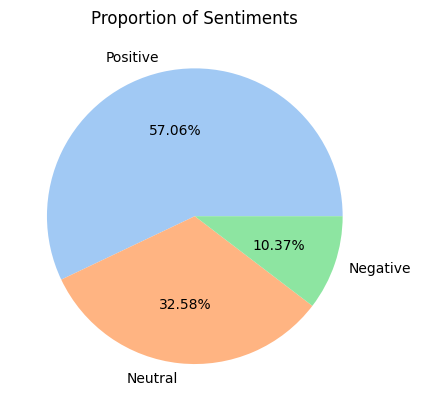

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

df['count'] = 1
df_table = pd.DataFrame(df.groupby('textblob_analysis')['count'].sum().sort_values(ascending=False).reset_index())    

colours = sns.color_palette('pastel')
labels = ['Positive', 'Neutral', 'Negative']

plt.pie(df_table['count'], labels=labels, colors=colours, autopct='%.2f%%')
plt.title("Proportion of Sentiments")
plt.show()

#### Step 23: *Visualize Sentiment Distribution of Movies*    

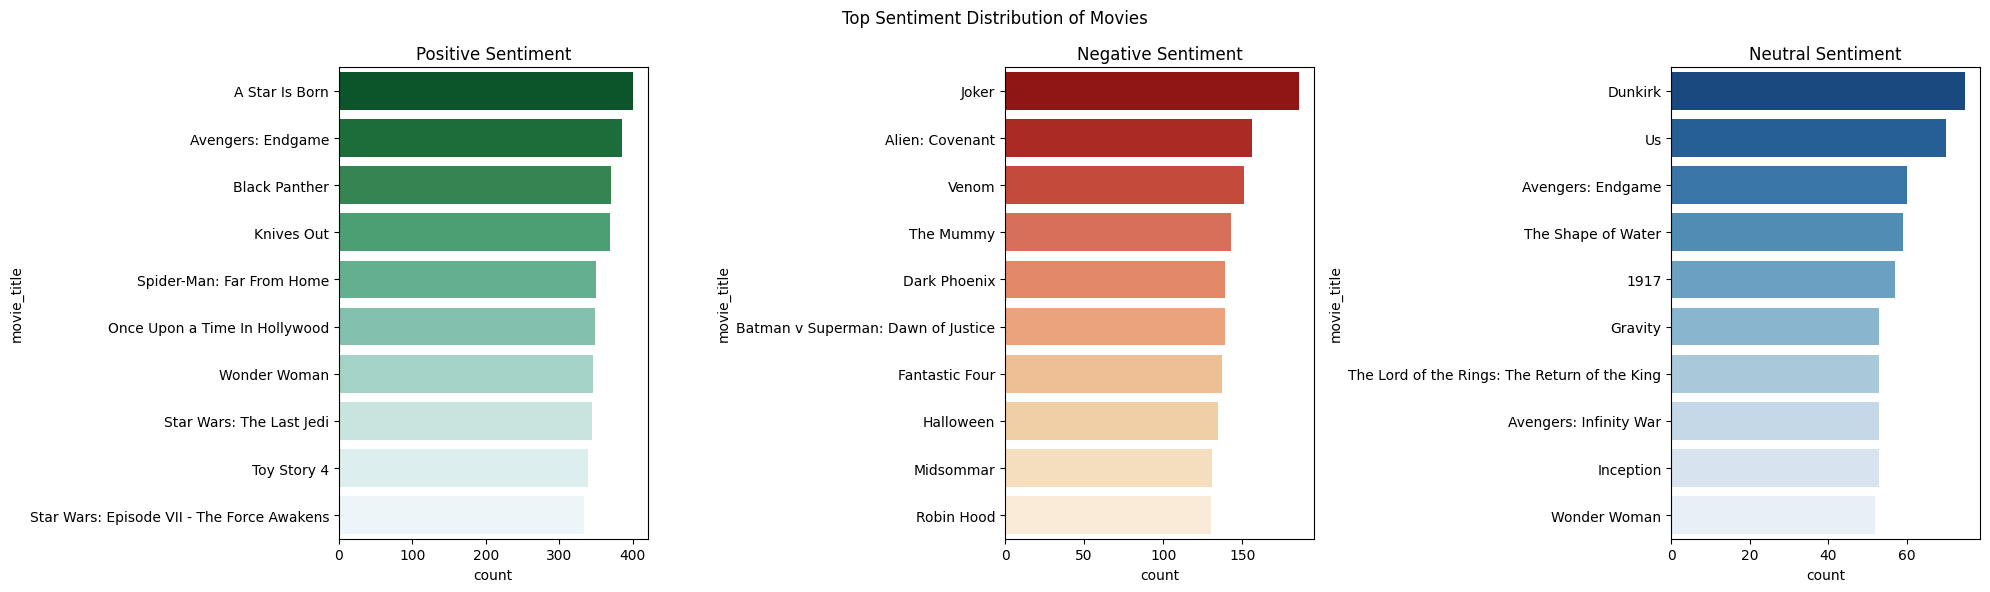

In [23]:
df_movie = df.groupby(['movie_title', 'textblob_analysis'], as_index=False)['count'].sum().sort_values(by=['count'], ascending=False).reset_index(drop=True)
df_movie_positive = df_movie.query('textblob_analysis == "Positive"').head(10).reset_index(drop=True)
df_movie_neutral = df_movie.query('textblob_analysis == "Neutral"').head(10).reset_index(drop=True)
df_movie_negative = df_movie.query('textblob_analysis == "Negative"').head(10).reset_index(drop=True)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Top Sentiment Distribution of Movies')

sns.barplot(ax=axes[0], x='count', y='movie_title', data=df_movie_positive, palette = ("BuGn_r"), orient='h').set(title='Positive Sentiment')
sns.barplot(ax=axes[1], x='count', y='movie_title', data=df_movie_negative, palette = 'OrRd_r', orient='h').set(title='Negative Sentiment')
sns.barplot(ax=axes[2], x='count', y='movie_title', data=df_movie_neutral, palette = 'Blues_r', orient='h').set(title='Neutral Sentiment')
plt.tight_layout()
plt.show()

#### Step 24: *Visualize Sentiment Distribution of Directors*    

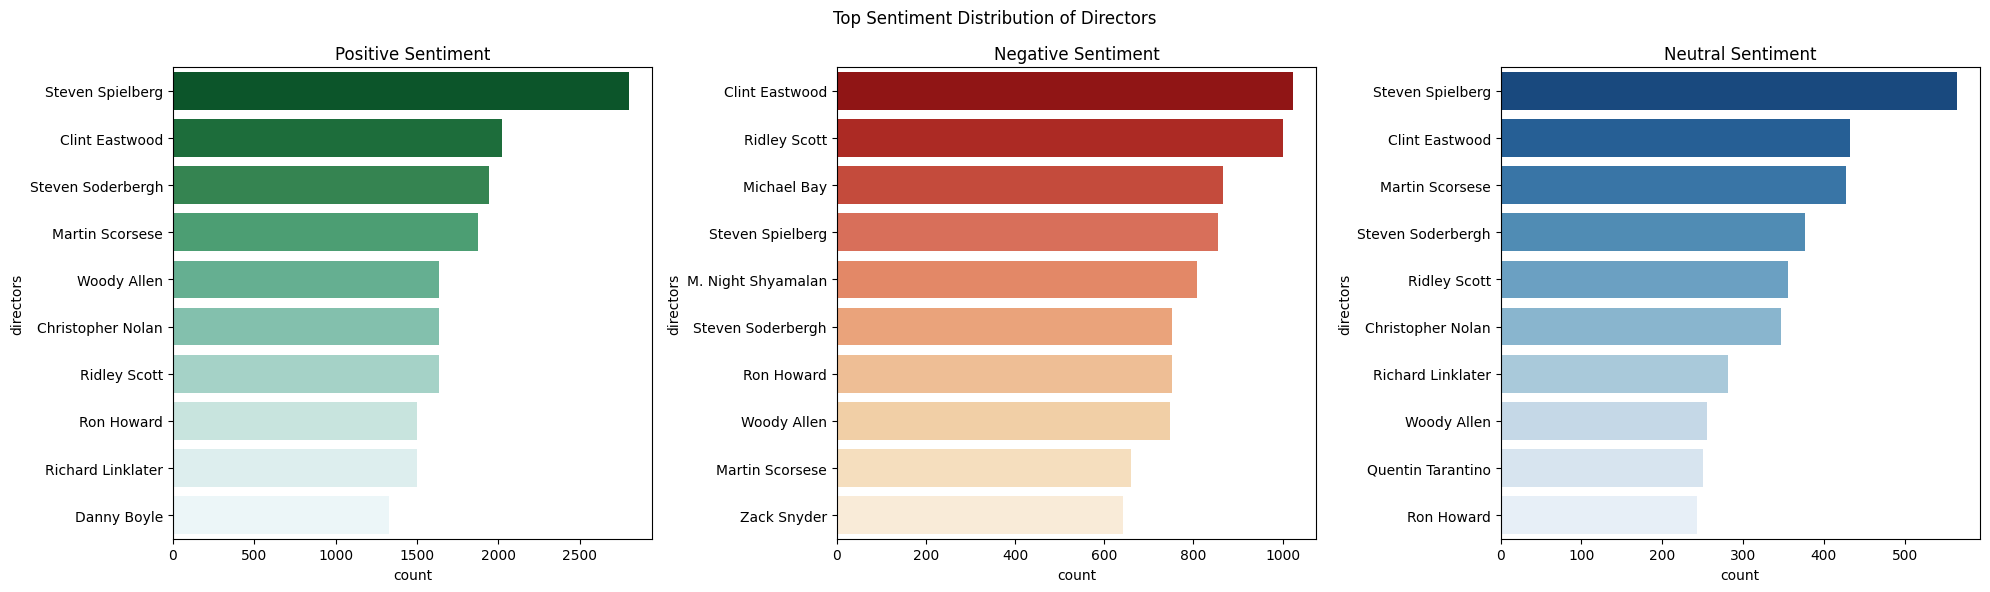

In [24]:
df_directors = df.groupby(['directors', 'textblob_analysis'], as_index=False)['count'].sum().sort_values(by=['count'], ascending=False).reset_index(drop=True)
df_directors.drop(df_directors[df_directors['directors'] == 'N/A'].index, inplace=True)
df_directors_positive = df_directors.query('textblob_analysis == "Positive"').head(10).reset_index(drop=True)
df_directors_neutral = df_directors.query('textblob_analysis == "Neutral"').head(10).reset_index(drop=True)
df_directors_negative = df_directors.query('textblob_analysis == "Negative"').head(10).reset_index(drop=True)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Top Sentiment Distribution of Directors')

sns.barplot(ax=axes[0], x='count', y='directors', data=df_directors_positive, palette = ("BuGn_r"), orient='h').set(title='Positive Sentiment')
sns.barplot(ax=axes[1], x='count', y='directors', data=df_directors_negative, palette = 'OrRd_r', orient='h').set(title='Negative Sentiment')
sns.barplot(ax=axes[2], x='count', y='directors', data=df_directors_neutral, palette = 'Blues_r', orient='h').set(title='Neutral Sentiment')
plt.tight_layout()
plt.show()

#### Step 24: *Visualize Sentiment Distribution of Production Companies*    

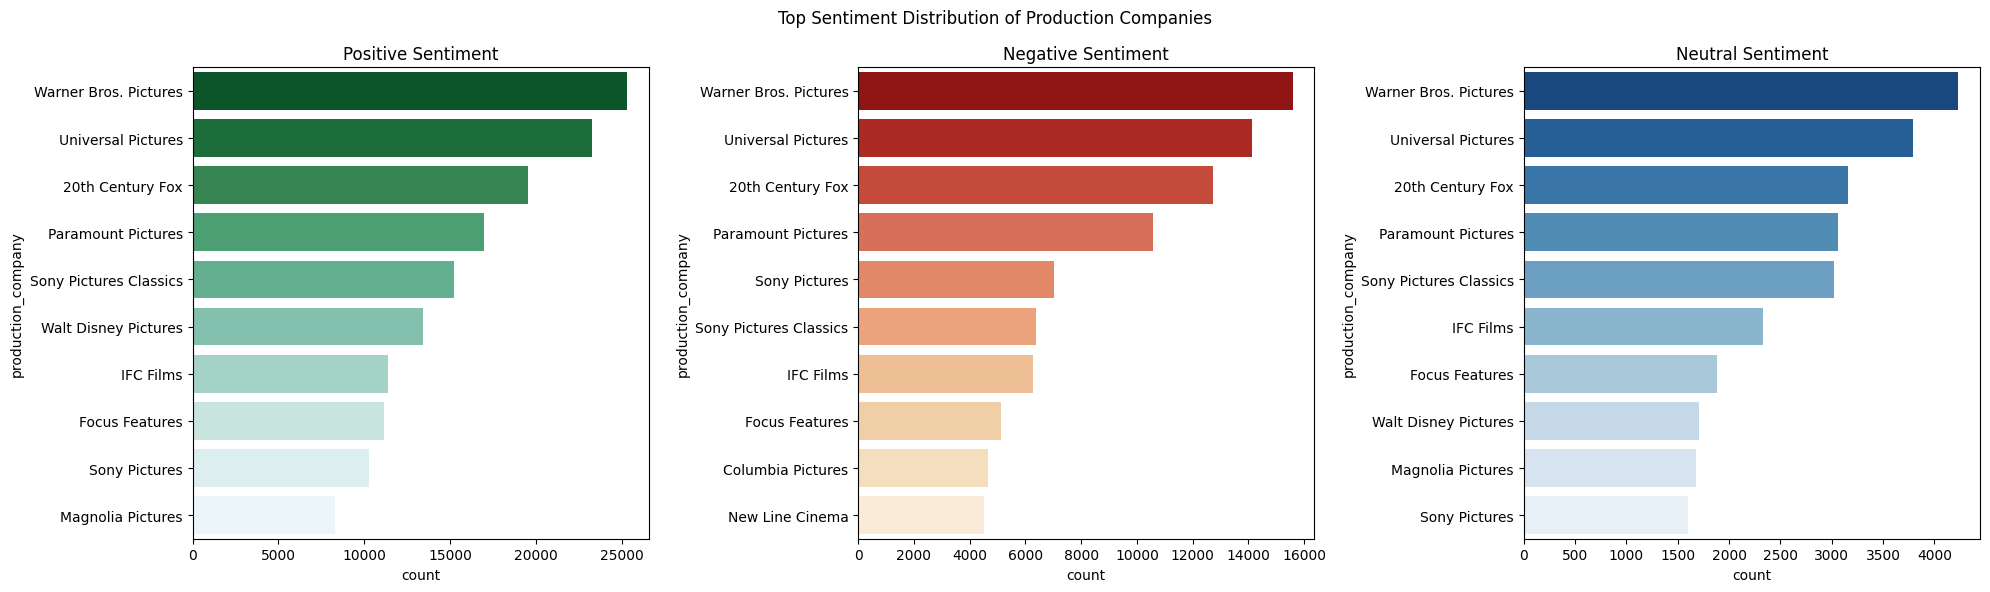

In [25]:
df_production = df.groupby(['production_company', 'textblob_analysis'], as_index=False)['count'].sum().sort_values(by=['count'], ascending=False).reset_index(drop=True)
df_production.drop(df_production[df_production['production_company'] == 'N/A'].index, inplace=True)
df_production_positive = df_production.query('textblob_analysis == "Positive"').head(10).reset_index(drop=True)
df_production_neutral = df_production.query('textblob_analysis == "Neutral"').head(10).reset_index(drop=True)
df_production_negative = df_production.query('textblob_analysis == "Negative"').head(10).reset_index(drop=True)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Top Sentiment Distribution of Production Companies')

sns.barplot(ax=axes[0], x='count', y='production_company', data=df_production_positive, palette = ("BuGn_r"), orient='h').set(title='Positive Sentiment')
sns.barplot(ax=axes[1], x='count', y='production_company', data=df_production_negative, palette = 'OrRd_r', orient='h').set(title='Negative Sentiment')
sns.barplot(ax=axes[2], x='count', y='production_company', data=df_production_neutral, palette = 'Blues_r', orient='h').set(title='Neutral Sentiment')
plt.tight_layout()
plt.show()

#### Step 25: *Visualize Sentiment Distribution of Critics*    

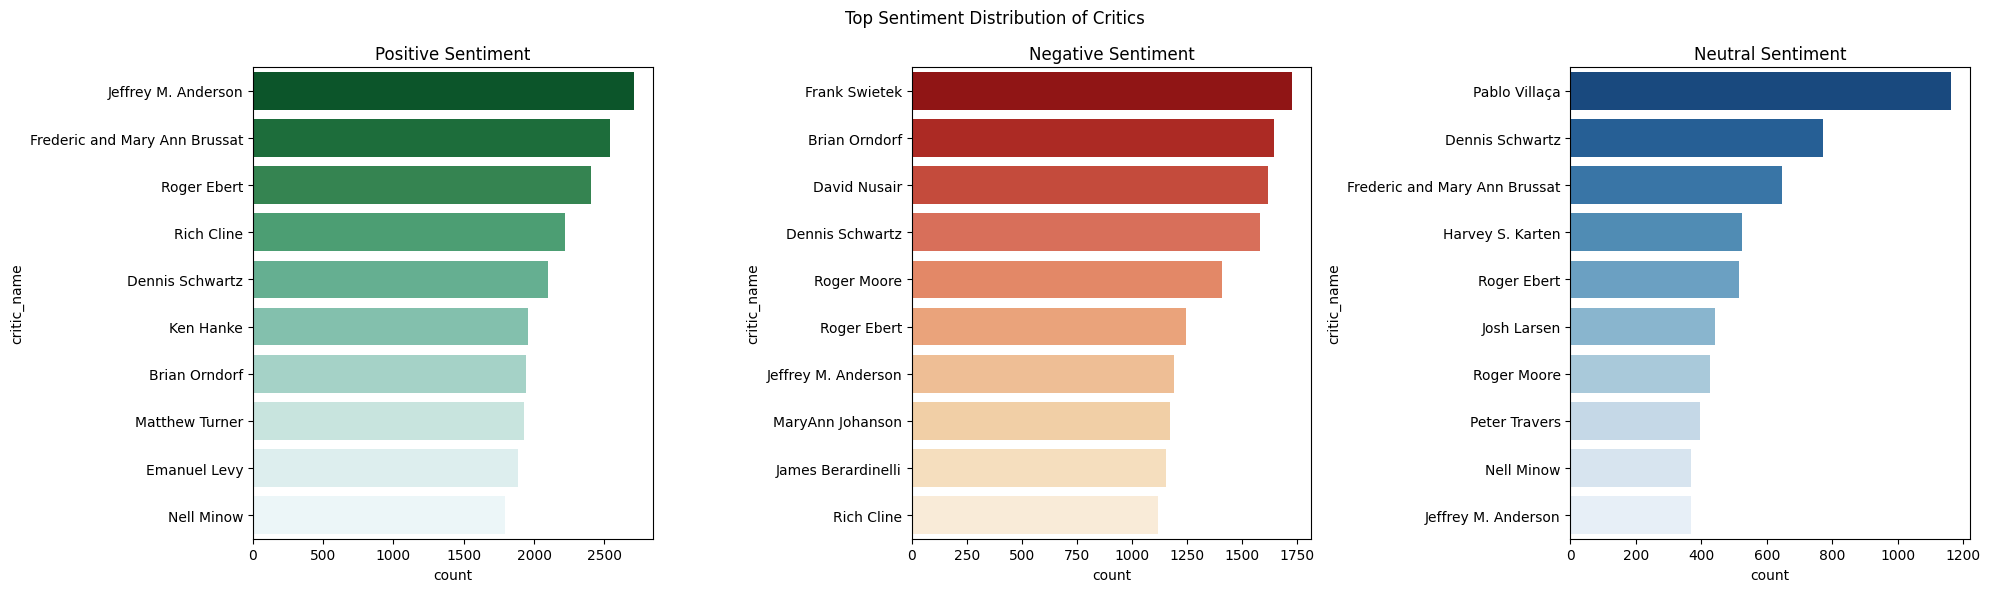

In [26]:
df_critic = df.groupby(['critic_name', 'textblob_analysis'], as_index=False)['count'].sum().sort_values(by=['count'], ascending=False).reset_index(drop=True)
df_critic.drop(df_critic[df_critic['critic_name'] == 'N/A'].index, inplace=True)
df_critic_positive = df_critic.query('textblob_analysis == "Positive"').head(10).reset_index(drop=True)
df_critic_neutral = df_critic.query('textblob_analysis == "Neutral"').head(10).reset_index(drop=True)
df_critic_negative = df_critic.query('textblob_analysis == "Negative"').head(10).reset_index(drop=True)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Top Sentiment Distribution of Critics')

sns.barplot(ax=axes[0], x='count', y='critic_name', data=df_critic_positive, palette = 'BuGn_r', orient='h').set(title='Positive Sentiment')
sns.barplot(ax=axes[1], x='count', y='critic_name', data=df_critic_negative, palette = 'OrRd_r', orient='h').set(title='Negative Sentiment')
sns.barplot(ax=axes[2], x='count', y='critic_name', data=df_critic_neutral, palette = 'Blues_r', orient='h').set(title='Neutral Sentiment')
plt.tight_layout()
plt.show()

#### Step 25: *Visualize Top Words used in the Sentiments*    

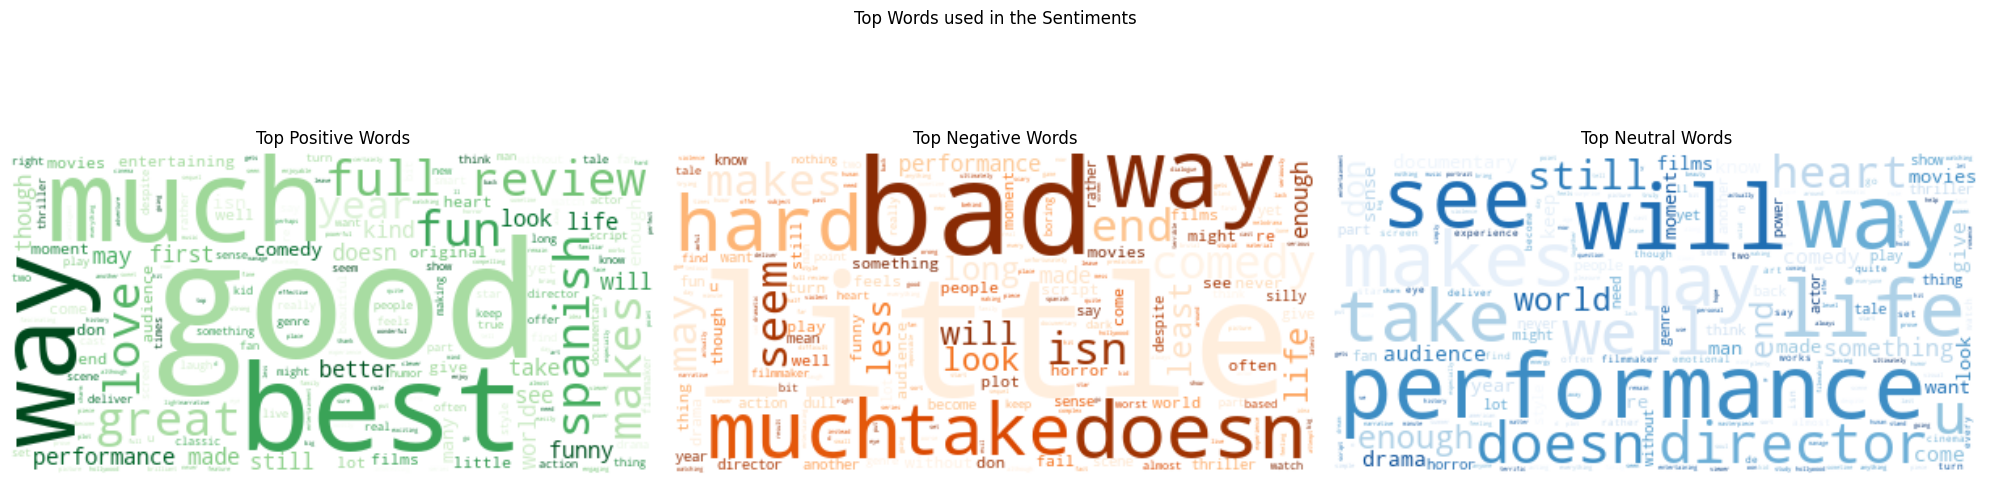

In [27]:
from wordcloud import WordCloud, STOPWORDS

df_positive = df.query("textblob_analysis == 'Positive'").reset_index(drop=True)
positive_text = ' '.join(word.lower() for word in df_positive['cleaned_reviews'])

df_negative = df.query("textblob_analysis == 'Negative'").reset_index(drop=True)
negative_text = ' '.join(word.lower() for word in df_negative['cleaned_reviews'])

df_neutral = df.query("textblob_analysis == 'Neutral'").reset_index(drop=True)
neutral_text = ' '.join(word.lower() for word in df_neutral['cleaned_reviews'])

stopwords = set(STOPWORDS)
stopwords.update(['movie', 'film', 'story', 'character', 's', 'one', 'make', 'even', 't', 'work', 'time', 'feel', 'characters'])

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Top Words used in the Sentiments')

wordcloud1 = WordCloud(stopwords=stopwords, background_color="white", colormap='Greens').generate(positive_text) 
wordcloud2 = WordCloud(stopwords=stopwords, background_color="white", colormap='Oranges').generate(negative_text) 
wordcloud3 = WordCloud(stopwords=stopwords, background_color="white", colormap='Blues').generate(neutral_text) 

axes[0].imshow(wordcloud1, interpolation='bilinear')
axes[0].set_title('Top Positive Words')
axes[0].set_axis_off()

axes[1].imshow(wordcloud2, interpolation='bilinear')
axes[1].set_title('Top Negative Words')
axes[1].set_axis_off()

axes[2].imshow(wordcloud3, interpolation='bilinear')
axes[2].set_title('Top Neutral Words')
axes[2].set_axis_off()

plt.tight_layout()
plt.show()